In [15]:
from torchvision import transforms
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
path = '/gdrive/MyDrive/'

# load model
model_path = 'berlin_bike_CV/CobblestoneModel/EfficientNet_CELoss_opti_all_param.pt'
model = torch.load(os.path.join(path, model_path), map_location=torch.device('cpu'))

In [18]:
# define layer for activation hook, and last layer weights
feature_layer = model.features
out_weights = model.classifier[1].fc1.weight

In [19]:
# define transformation used in classification model
image_height = 256
image_width = 256

image_transforms = transforms.Compose([transforms.Resize((image_height, image_width)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [20]:
### chose image to examine class activation map

## cobblestone example
channel = 1
image_path = '/gdrive/MyDrive/berlin_bike_CV/final_project_first_images/test/cobblestones/cobblestones_027.jpg'

## asphalt example
# channel = 0
# image_path = '/gdrive/MyDrive/berlin_bike_CV/final_project_first_images/test/road/road_030.jpg'

In [21]:
# class for activation layer hook
class ActivationHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_func)
        self.activation = None

    def hook_func(self, module, input, output):
        self.activation = output.detach()

    def close(self):
        self.hook.remove()

In [26]:
# activate model evaluation mode
model.eval()

# create activation hook
activation_hook = ActivationHook(feature_layer)

# load image
image = image_transforms(Image.open(image_path)).unsqueeze(0)

# feedforward image to the model
with torch.no_grad():
    output = model(image)

print(output.squeeze().numpy())

# take activations and weights
activations = activation_hook.activation[0]
weights = out_weights

# close hook
activation_hook.close()

# create cam
cam_map = torch.einsum('ck,kij->cij', out_weights, activations)

[2.1951338e-12 1.0000000e+00]


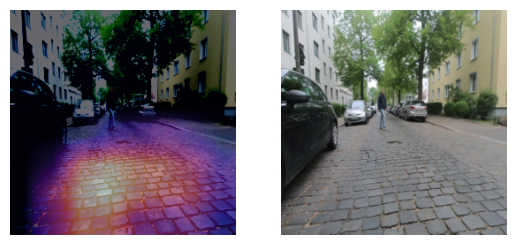

In [23]:
# plot image and CAM
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(image.squeeze().permute(1, 2, 0))
ax1.imshow(cam_map[channel].detach().cpu(), alpha=0.6, extent=(0, image.shape[3], image.shape[2], 0),
          interpolation='bilinear', cmap='magma')
ax1.axis('off')

img = transforms.Resize((image_height, image_width))(Image.open(image_path))
ax2.imshow(img)
ax2.axis('off')
plt.show()